In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 28.9 MB/s eta 0:00:00


CNN Exp 1 E vs S
NO optimser

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5668 - loss: 55.9506 - val_accuracy: 0.5167 - val_loss: 32.1883
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4097 - loss: 44.4378 - val_accuracy: 0.9167 - val_loss: 1.7423
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8261 - loss: 3.2895 - val_accuracy: 0.9000 - val_loss: 1.1833
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8990 - loss: 1.1552 - val_accuracy: 0.9000 - val_loss: 1.1054
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9491 - loss: 0.5550 - val_accuracy: 0.9167 - val_loss: 1.5691
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9712 - loss: 0.1870 - val_accuracy: 0.8833 - val_loss: 0.7693
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9495 - loss: 0.4577 - val_accuracy: 0.8667 - val_loss: 0.7317
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9738 - loss: 0.5129 - val_accuracy: 0.9000 - val_loss: 0.7545
Epoch 9/

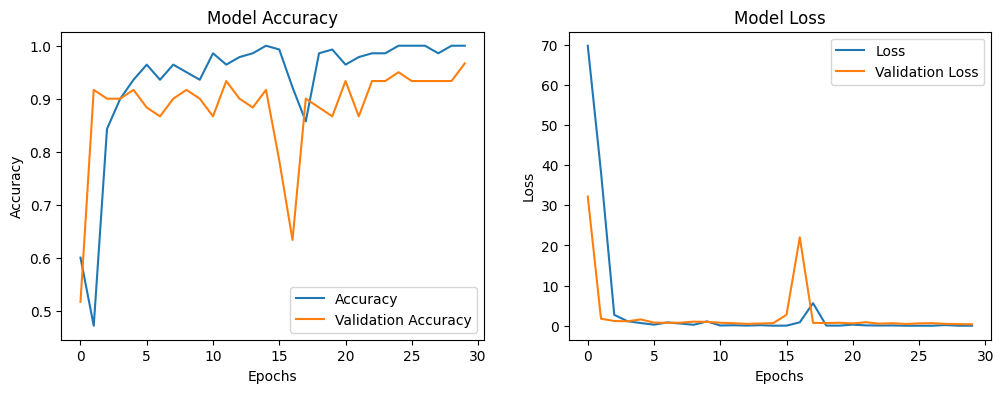

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp2/No_Options.keras ✅


In [6]:
from google.colab import drive
import os
import numpy as np
import pywt
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# Function to load data from a directory and apply wavelet transform
def load_data_from_directory(directory_path, label, wavelet='db4', level=5):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file and apply wavelet transform
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            # Apply discrete wavelet transform (db4, level 5)
            coeffs = pywt.wavedec(file_data, wavelet, level=level)
            # Use only the approximation coefficients (first element of coeffs)
            wavelet_features = coeffs[0]
            data.append(wavelet_features)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_E = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # E(n folder)
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizeur (S)

# Load data
data_E, labels_E = load_data_from_directory(path_E, label=0)  # E (label 0)
data_S, labels_S = load_data_from_directory(path_S, label=1)  # Seizure (S, label 1)

# Combine data and labels
if data_E.size > 0 and data_S.size > 0:
    data_all = np.concatenate((data_E, data_S), axis=0)
    labels_all = np.concatenate((labels_E, labels_S), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for E, 1 for S)
    ])

    # Compile the model (no optimizer specified)
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])

    # Start timer for training time
    start_time = time.time()

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)

    # Stop timer and calculate training time
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


        # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp2/No_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")



With Standerscaler

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.5353 - loss: 0.7913 - val_accuracy: 0.4833 - val_loss: 0.6055
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5811 - loss: 0.5656 - val_accuracy: 0.5167 - val_loss: 0.5509
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7207 - loss: 0.4880 - val_accuracy: 0.7000 - val_loss: 0.4885
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8441 - loss: 0.4191 - val_accuracy: 0.8833 - val_loss: 0.4017
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9187 - loss: 0.3357 - val_accuracy: 0.7167 - val_loss: 0.5239
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7007 - loss: 0.5569 - val_accuracy: 0.8833 - val_loss: 0.3311
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9521 - loss: 0.2727 - val_accuracy: 0.6000 - val_loss: 0.6009
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9050 - loss: 0.3251 - val_accuracy: 0.9167 - val_loss: 0.2791
Epoch 9/30


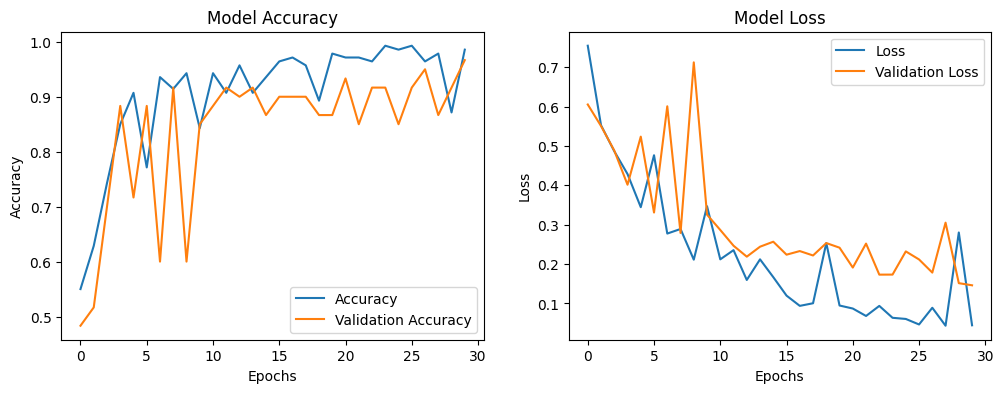

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp2/With_Stander.keras ✅


In [4]:
from google.colab import drive
import os
import numpy as np
import pywt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# Function to load data from a directory and apply wavelet transform
def load_data_from_directory(directory_path, label, wavelet='db4', level=5):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file and apply wavelet transform
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            # Apply discrete wavelet transform (db4, level 5)
            coeffs = pywt.wavedec(file_data, wavelet, level=level)
            # Use only the approximation coefficients (first element of coeffs)
            wavelet_features = coeffs[0]
            data.append(wavelet_features)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_E = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # E(n folder)
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizeur (S)

# Load data
data_E, labels_E = load_data_from_directory(path_E, label=0)  # E (label 0)
data_S, labels_S = load_data_from_directory(path_S, label=1)  # Seizure (S, label 1)

# Combine data and labels
if data_E.size > 0 and data_S.size > 0:
    data_all = np.concatenate((data_E, data_S), axis=0)
    labels_all = np.concatenate((labels_E, labels_S), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Standardize the data using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data and transform
    X_test_scaled = scaler.transform(X_test)  # Only transform the test data

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for E, 1 for S)
    ])

    # Compile the model (no optimizer specified)
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])

    # Start timer for training time
    start_time = time.time()

    # Train the model
    history = model.fit(X_train_scaled[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test_scaled[..., np.newaxis], y_test), verbose=1)

    # Stop timer and calculate training time
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Evaluate the model
    y_pred = model.predict(X_test_scaled[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


    # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp2/With_Stander.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")



With optimiser

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.4751 - loss: 116.8828 - val_accuracy: 0.4833 - val_loss: 49.3920
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6125 - loss: 23.4659 - val_accuracy: 0.6000 - val_loss: 22.2406
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6034 - loss: 31.5900 - val_accuracy: 0.5500 - val_loss: 6.0970
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7106 - loss: 4.7482 - val_accuracy: 0.7500 - val_loss: 1.2649
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8532 - loss: 1.7867 - val_accuracy: 0.8833 - val_loss: 0.5803
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8081 - loss: 1.6838 - val_accuracy: 0.8500 - val_loss: 0.3368
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8428 - loss: 0.7133 - val_accuracy: 0.8500 - val_loss: 0.4434
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8695 - loss: 0.7679 - val_accuracy: 0.8167 - val_loss: 0.6862
Epoc

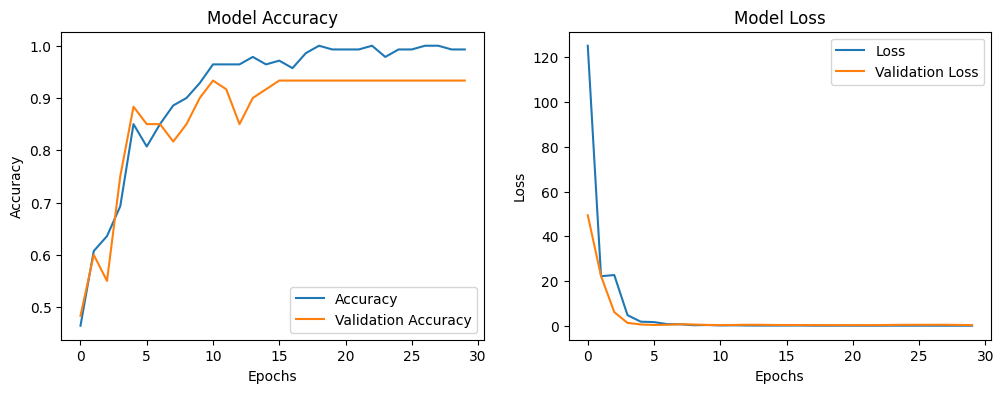

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp2/With_Optimiser.keras ✅


In [7]:
from google.colab import drive
import os
import numpy as np
import pywt
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# Function to load data from a directory and apply wavelet transform
def load_data_from_directory(directory_path, label, wavelet='db4', level=5):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file and apply wavelet transform
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            # Apply discrete wavelet transform (db4, level 5)
            coeffs = pywt.wavedec(file_data, wavelet, level=level)
            # Use only the approximation coefficients (first element of coeffs)
            wavelet_features = coeffs[0]
            data.append(wavelet_features)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_E = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # E(n folder)
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizeur (S)

# Load data
data_E, labels_E = load_data_from_directory(path_E, label=0)  # E (label 0)
data_S, labels_S = load_data_from_directory(path_S, label=1)  # Seizure (S, label 1)

# Combine data and labels
if data_E.size > 0 and data_S.size > 0:
    data_all = np.concatenate((data_E, data_S), axis=0)
    labels_all = np.concatenate((labels_E, labels_S), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for E, 1 for S)
    ])

    # Compile the model with the Adam optimizer
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Start timer for training time
    start_time = time.time()

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)

    # Stop timer and calculate training time
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")



     # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp2/With_Optimiser.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


Both Optmiser and Standa

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.4976 - loss: 0.6491 - val_accuracy: 0.4833 - val_loss: 0.6127
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6521 - loss: 0.5601 - val_accuracy: 0.7667 - val_loss: 0.5097
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8586 - loss: 0.4308 - val_accuracy: 0.8833 - val_loss: 0.4092
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8500 - loss: 0.3943 - val_accuracy: 0.8333 - val_loss: 0.3837
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9200 - loss: 0.2923 - val_accuracy: 0.9000 - val_loss: 0.2881
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9063 - loss: 0.2469 - val_accuracy: 0.9000 - val_loss: 0.3010
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9343 - loss: 0.2161 - val_accuracy: 0.9167 - val_loss: 0.2336
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9445 - loss: 0.1556 - val_accuracy: 0.8667 - val_loss: 0.2864
Epoch 9/30


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

Final Evaluation Metrics:
Test Accuracy:  0.8333333333333334
Test Recall (Sensitivity):  0.9310344827586207
Test Precision:  0.7714285714285715
Test Specificity:  0.7419354838709677
Confusion Matrix: 
 [[23  8]
 [ 2 27]]


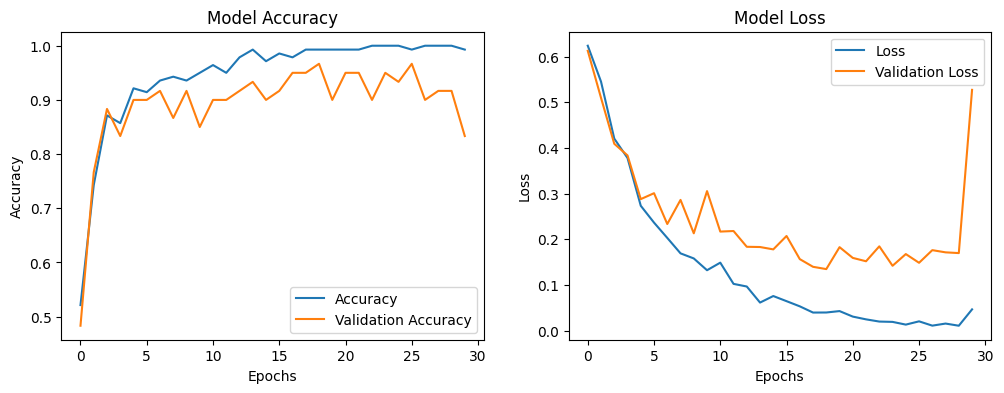

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp2/With_Options.keras ✅


In [5]:
from google.colab import drive
import os
import numpy as np
import pywt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# Function to load data from a directory and apply wavelet transform
def load_data_from_directory(directory_path, label, wavelet='db4', level=5):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file and apply wavelet transform
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            # Apply discrete wavelet transform (db4, level 5)
            coeffs = pywt.wavedec(file_data, wavelet, level=level)
            # Use only the approximation coefficients (first element of coeffs)
            wavelet_features = coeffs[0]
            data.append(wavelet_features)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_E = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # E(n folder)
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizeur (S)

# Load data
data_E, labels_E = load_data_from_directory(path_E, label=0)  # E (label 0)
data_S, labels_S = load_data_from_directory(path_S, label=1)  # Seizure (S, label 1)

# Combine data and labels
if data_E.size > 0 and data_S.size > 0:
    data_all = np.concatenate((data_E, data_S), axis=0)
    labels_all = np.concatenate((labels_E, labels_S), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Apply StandardScaler to the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the CNN model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (0 for E, 1 for S)
    ])

    # Compile the model with the Adam optimizer
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Start timer for training time
    start_time = time.time()

    # Train the model
    history = model.fit(X_train_scaled[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test_scaled[..., np.newaxis], y_test), verbose=1)

    # Stop timer and calculate training time
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Evaluate the model
    y_pred = model.predict(X_test_scaled[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


        # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp2/With_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")

